In [3]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd

# scipyの統計パッケージも使います。
from scipy import stats

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa

# 描画のためのライブラリです。
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ブラウザ内に画像を埋め込むための命令です
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

In [4]:
def ShowDiagnostics(res, nMaxLag):
    # Purpose: Show diagnostics table
    # Args:        res:    Result of statsmodels
    #          nMaxLag:    max lag for BoxLjung
    
    ## Get statistics
    # Indipendence check
    Q  = res.test_serial_correlation('ljungbox',nMaxLag)
    Q  = Q[0,0][nMaxLag-1]
    Qc = stats.chi2.ppf(0.95,nMaxLag-len(res.params)+1)
    # Heteroskewdasticity check
    tmp = res.filtered_state.shape # Number of state variables
    n   = tmp[1]
    d   = tmp[0]
    nBlockSize = round((n-d)/3)
    H   = res.test_heteroskedasticity('breakvar')
    H   = H[0,0]
    Hc  = stats.f.ppf(0.975,nBlockSize,nBlockSize)
    # Normality check
    N  = res.test_normality('jarquebera')
    N  = N[0,0]
    Nc = stats.chi2.ppf(0.95,2)
    
    value     = np.array([Q,H,N])
    critical  = np.array([Qc,Hc,Nc])
    condition = (value <= critical)
    satisfied = np.where(condition, '+', '-')
    
    dfDiag = pd.DataFrame({
        '1. Stat':      ['Q'+str(nMaxLag), 'H'+str(nBlockSize), 'N'],
        '2. Value':     value,
        '3. Critical':  critical,
        '4. Satisfied': satisfied},
        index = ['Independence','Homoscedasticity','Normality'])
    
    # Standalized resid
    stdError = res.filter_results.standardized_forecasts_error
    rc  = 2/np.sqrt(n)
    fig = tsa.plot_acf(stdError[0],lags=nMaxLag,alpha=None)
    plt.fill_between(np.arange(1,nMaxLag+1,1),-rc,rc,alpha=0.2)
    
    # Calculate AIC
    AIC = (1/n)*(-2*res.llf+2*(d + len(res.params)))
    print('AIC='+str(AIC))
    
    return dfDiag
        
                           

In [5]:
#データの読み込み
df = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None)
#インデックスを以下のように設定 (MSは月毎の意味)
df.index = pd.date_range('1969-JAN', '1984-DEC', freq='MS')
#コラム名を変更
df.columns = ['KSI']
#対数KSIを計算してコラムに追加
df['logKSI'] = np.log(df['KSI'])

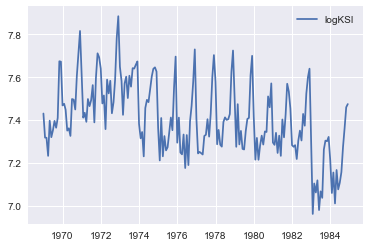

In [6]:
# データのプロット
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.legend()

本章では、上記の数列を、状態空間モデルの基本的なモデルとして、ローカル・レベル・モデルを用いて表す。
このモデルは、次のように表すことができる。

$y_i = \mu_i + \epsilon_i,    \epsilon_i = N(0,{\sigma_\epsilon}^2)$


$\mu_{i+1} = \mu_i + \zeta_i,    \eta_i = N(0,{\sigma_\zeta}^2)$


# 2.1 確定的レベル

In [7]:
#http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

KSI_detmodel = sm.tsa.UnobservedComponents(df['logKSI'], 'deterministic constant')
KSI_detresults = KSI_detmodel.fit()
print(KSI_detresults.summary())

                          Unobserved Components Results                           
Dep. Variable:                     logKSI   No. Observations:                  192
Model:             deterministic constant   Log Likelihood                  63.314
Date:                    Sun, 07 May 2017   AIC                           -124.628
Time:                            19:51:03   BIC                           -121.370
Sample:                        01-01-1969   HQIC                          -123.308
                             - 12-01-1984                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0294      0.003      8.987      0.000       0.023       0.036
Ljung-Box (Q):                      637.74   Jarque-Bera (JB):                 0.

注意：KC本でのAICは、nで正規化されているが、上の結果はされていないものである。
また、モデルのパラメータ数として、上の結果は1(つまり、観測分散しか入っていない)だが、
KC本では、2となっている。

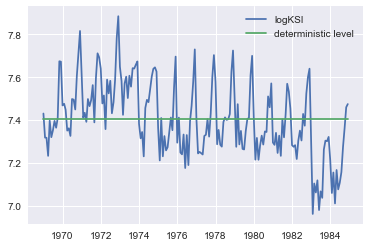

In [8]:
# 図2.2 確定的レベルのプロット
df['deterministic level'] = KSI_detresults.smoothed_state[0]
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.plot(df.index,df['deterministic level'],label='deterministic level')
plt.legend()

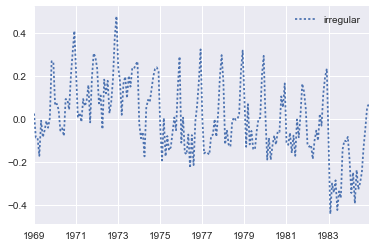

In [9]:
#図2.3 確定的レベル・モデルに対する不規則要素
df['irregular'] = df['logKSI']-KSI_detresults.smoothed_state[0]
df.plot(y='irregular',style=':')

確定的レベルモデルの診断テスト結果は以下の通り。

AIC=-0.638686005297


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q15,415.211584,24.995790,-
Homoscedasticity,H64,2.057694,1.639485,-
Normality,N,0.733251,5.991465,+


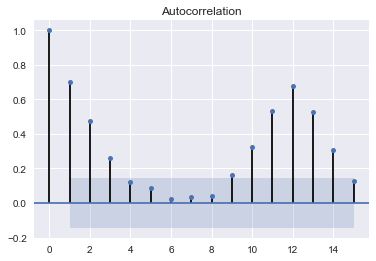

In [10]:
ShowDiagnostics(KSI_detresults,15)

# 2.2 確率的レベル

In [36]:
#http://www.chadfulton.com/topics/local_level_nile.html
class MLELocalLevel(sm.tsa.statespace.MLEModel):
    start_params = [1.0, 1.0]
    param_names = ['obs.var', 'level.var']

    def __init__(self, endog):
        super(MLELocalLevel, self).__init__(endog, k_states=1)

        self['design', 0, 0] = 1.0
        self['transition', 0, 0] = 1.0
        self['selection', 0, 0] = 1.0

        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 1

    def transform_params(self, params):
        return params**2

    def untransform_params(self, params):
        return params**0.5

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(MLELocalLevel, self).update(params, **kwargs)

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]

In [37]:
KSI_model = MLELocalLevel(df['logKSI'])

In [38]:
KSI_results = KSI_model.fit()

In [39]:
print(KSI_results.summary())

                           Statespace Model Results                           
Dep. Variable:                 logKSI   No. Observations:                  192
Model:                  MLELocalLevel   Log Likelihood                 123.878
Date:                Sun, 07 May 2017   AIC                           -243.755
Time:                        19:59:36   BIC                           -237.240
Sample:                    01-01-1969   HQIC                          -241.117
                         - 12-01-1984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
obs.var        0.0022      0.001      2.172      0.030       0.000       0.004
level.var      0.0119      0.002      5.926      0.000       0.008       0.016
Ljung-Box (Q):                      273.90   Jarque-

In [40]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
df['stochastic level'] = KSI_results.smoothed_state[0]
df['irregular2'] = df['logKSI']-df['stochastic level']

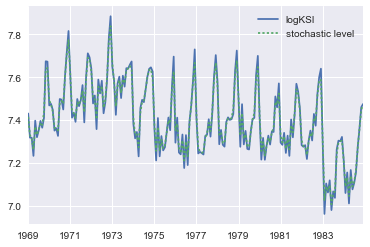

In [41]:
#データをプロット
fig, ax = plt.subplots(1,1)
df.plot(y='logKSI',ax=ax)
df.plot(y='stochastic level', style=':', ax=ax)

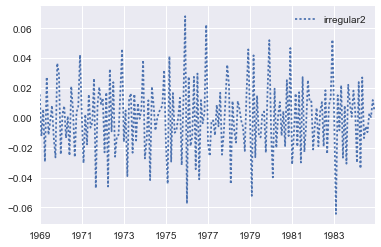

In [42]:
df.plot(y='irregular2',style=':')

AIC=-1.25914195195


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q15,105.415617,23.684791,-
Homoscedasticity,H64,1.064032,1.639485,+
Normality,N,13.243267,5.991465,-


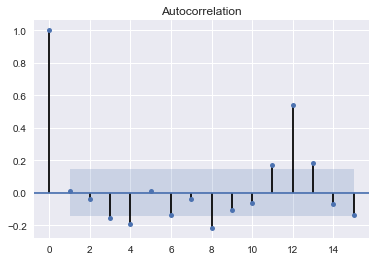

In [43]:
ShowDiagnostics(KSI_results,15)

# 2.3 ローカル・レベル・モデルとノルウェイの事故

1970年から2003年の34年間に観測されたノルウェイでの年次の道路交通事故数の対数にローカル・レベル・モデルを適用。

,year,Norway,Finland,logNorway,logFinland
1970-01-01,1970,560,1055,6.327937,6.961296
1971-01-01,1971,533,1143,6.278521,7.041412
1972-01-01,1972,490,1156,6.194405,7.052721
1973-01-01,1973,511,1086,6.236370,6.990257
1974-01-01,1974,509,865,6.232448,6.762730


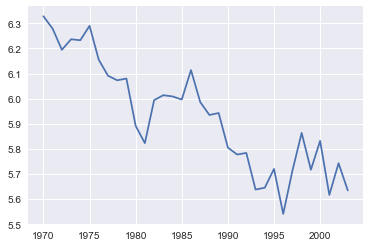

In [46]:
#データの読み込み
dfFin = pd.read_table('Norwayfinland.txt', skiprows=1, header=None)
dfFin.columns = ['year','Norway','Finland']
dfFin['logNorway']  = np.log(dfFin['Norway'])
dfFin['logFinland'] = np.log(dfFin['Finland'])
dfFin.index = pd.date_range('1970', '2003', freq='AS')

# オリジナルのデータ
plt.plot(dfFin['year'],dfFin['logNorway'])
dfFin.head()

In [48]:
NorModel = MLELocalLevel(dfFin['logNorway'])
Nor_results = NorModel.fit()
print(Nor_results.summary())

                           Statespace Model Results                           
Dep. Variable:              logNorway   No. Observations:                   34
Model:                  MLELocalLevel   Log Likelihood                  28.793
Date:                Sun, 07 May 2017   AIC                            -53.587
Time:                        20:01:37   BIC                            -50.534
Sample:                    01-01-1970   HQIC                           -52.546
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
obs.var        0.0033      0.002      1.533      0.125      -0.001       0.007
level.var      0.0047      0.003      1.638      0.101      -0.001       0.010
Ljung-Box (Q):                       19.96   Jarque-

In [53]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
dfFin['stochastic level'] = Nor_results.smoother_results.smoothed_state[0]
dfFin['irregular'] = dfFin['logNorway']-dfFin['stochastic level']

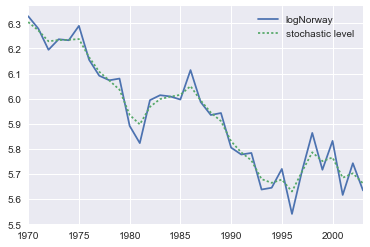

In [54]:
#図2.5 ノルウェイの事故に対する確率的レベル
fig, ax = plt.subplots(1,1)
dfFin.plot(y='logNorway',ax=ax)
dfFin.plot(y='stochastic level', style=':', ax=ax)

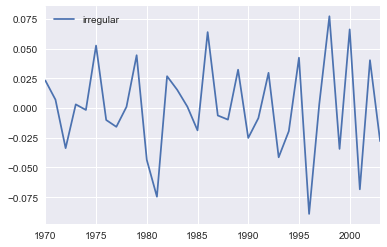

In [55]:
#図2.6
dfFin.plot(y='irregular')

AIC=-1.51725385377


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q10,6.228401,16.918978,+
Homoscedasticity,H11,1.746137,3.473699,+
Normality,N,1.190689,5.991465,+


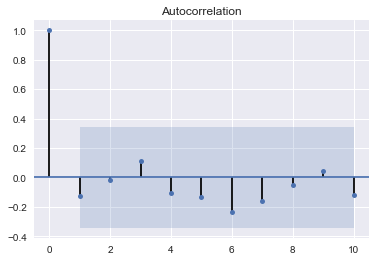

In [56]:
# 診断テストの結果
ShowDiagnostics(Nor_results,10)

かなりいい感じ。ちなみに確定的モデルの結果は・・・

In [57]:
Nor_detmodel = sm.tsa.UnobservedComponents(dfFin['logNorway'], 'deterministic constant')
Nor_detresults = Nor_detmodel.fit()
print(KSI_detresults.summary())

                          Unobserved Components Results                           
Dep. Variable:                     logKSI   No. Observations:                  192
Model:             deterministic constant   Log Likelihood                  63.314
Date:                    Sun, 07 May 2017   AIC                           -124.628
Time:                            20:11:01   BIC                           -121.370
Sample:                        01-01-1969   HQIC                          -123.308
                             - 12-01-1984                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0294      0.003      8.987      0.000       0.023       0.036
Ljung-Box (Q):                      637.74   Jarque-Bera (JB):                 0.

AIC=0.0402448919165


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q10,29.258847,18.307038,-
Homoscedasticity,H11,3.661236,3.473699,-
Normality,N,1.241290,5.991465,+


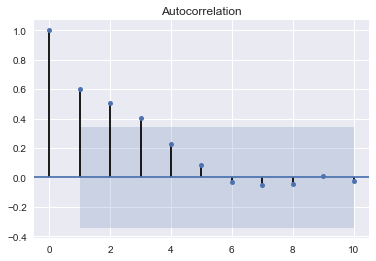

In [58]:
ShowDiagnostics(Nor_detresults,10)

独立性、均一分散性ともにNGとなり、モデルは妥当でない。
また、AICは0.04とかなり低い。この数列に対しては、ローカルレベルモデルの採用が適切という例。